# Check that current differential equation agrees with stress function

Generate data in usual way, calculate full library, determine coeffs, assess correctness of equation at each data point.

### Data Gen

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sys

sys.path.append('../')
sys.path.append('../src')
import data.Generation.VE_DataGen_Functions as vedg
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

In [2]:
Input_Type = 'Strain'
E = [1, 10, 1]
eta = [20, 20]
t = sym.symbols('t', real=True)
Input_Function = sym.sinc(t)
Input_Description = 'Sinc'
Int_Type = 'Numerical'

In [3]:
Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, eta, Input_Function, Int_Type, t)
Tuple_of_Expressions

(1.0 + 10.0*exp(-t/2) + 1.0*exp(-t/20),
 <function data.Generation.VE_DataGen_Functions.Stress_Strain_Master_Int.<locals>.<lambda>(t)>)

<class 'numpy.float64'>
<class 'numpy.float64'>


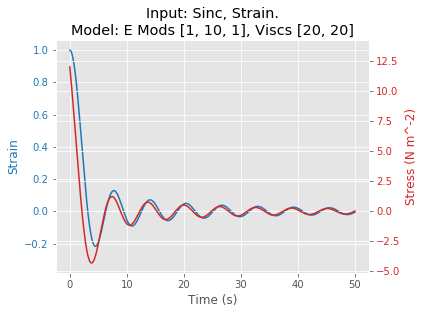

In [4]:
time_array = np.linspace(0.001, 50, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(eta))

strain_array, stress_array = vedg.Eval_Graph_Strain_Stress(title, time_array, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

### Calculate library

In [6]:
def num_derivs(dependent_data, independent_data, diff_order):
    
    data_derivs = dependent_data.copy()
    data_derivs = data_derivs.reshape(-1, 1)
    for _ in range(diff_order):
        data_derivs = np.append(data_derivs, np.gradient(data_derivs[:, -1].flatten(), independent_data.flatten()).reshape(-1,1), axis=1)
    
    return data_derivs

In [7]:
diff_order = 2

strain_theta = num_derivs(strain_array, time_array, diff_order)
stress_theta = num_derivs(stress_array, time_array, diff_order)
num_theta = np.append(strain_theta, stress_theta, axis=1)
num_theta.shape

(5000, 6)

(-0.3, 0.3)

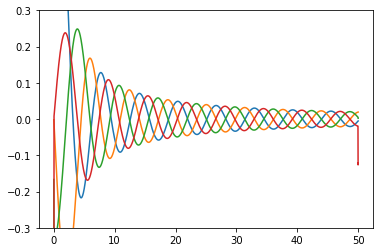

In [10]:
for idx in np.arange(strain_theta.shape[1]):
    plt.plot(time_array, strain_theta[:, idx])

plt.ylim([-0.3, 0.3])

(-2, 2)

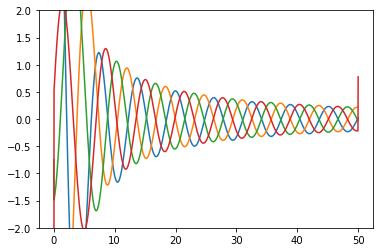

In [12]:
for idx in np.arange(stress_theta.shape[1]):
    plt.plot(time_array, stress_theta[:, idx])

plt.ylim([-2, 2])

### Calculate coeffs

In [13]:
not_floats = coeffs_from_model_params(E, eta)
not_floats

[1/22, 20/11, 21/220, 13/11, 20/11]

In [14]:
coeffs = [-1*not_floats[0]] + [-1] + [-1*not_floats[1]] + [0] + not_floats[2:] + [0]
# negatives added to imitate transfer of LHS of equation to RHS.
coeffs_array = np.array(coeffs).reshape(-1, 1)
print(coeffs_array.shape)
coeffs_array

(8, 1)


array([[-1/22],
       [-1],
       [-20/11],
       [0],
       [21/220],
       [13/11],
       [20/11],
       [0]], dtype=object)

### Assess correctness

In [15]:
equation_residuals = num_theta @ coeffs_array
equation_residuals.shape

(5000, 1)

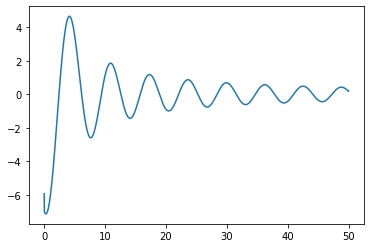

In [16]:
plt.plot(time_array, equation_residuals.flatten())

Answer: no

## Look at size of LHS and RHS of equation

In [25]:
LHS = strain_theta @ coeffs_array[:4, 0]
LHS.shape

(5000,)

In [26]:
RHS = stress_theta @ coeffs_array[4:, 0]
RHS

array([-6.19071207369066, -6.88068205840633, -7.57510470312868, ...,
       0.200295792191073, 0.212285313317787, 0.226405442289680],
      dtype=object)

(-0.1, 0.1)

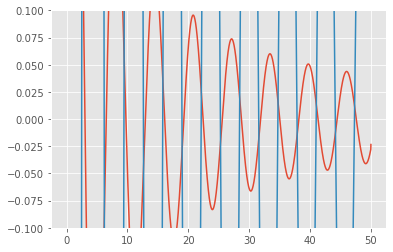

In [35]:
plt.plot(time_array, LHS.flatten())
plt.plot(time_array, RHS.flatten())
plt.ylim([-0.1, 0.1])

In [31]:
LHS_plot = np.gradient(LHS.flatten(), time_array)
RHS_plot = np.gradient(RHS.flatten(), time_array)

(-1, 1)

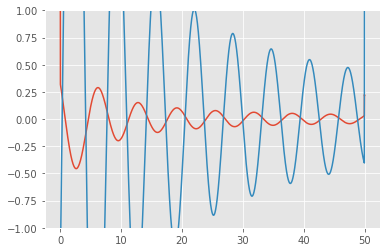

In [32]:
plt.plot(time_array, LHS_plot)
plt.plot(time_array, RHS_plot)
plt.ylim([-1, 1])

Extra note, these above two graphs clearly show that the LHS and RHS are not in phase.

However, this is not indicative of much as far as I can think

## Use Least squares method to find coeffs from numerical diffs

In [64]:
b = num_theta[:, 1:2]
b

array([[-0.00200029],
       [-0.00366719],
       [-0.00700082],
       ...,
       [ 0.01931059],
       [ 0.01935825],
       [ 0.01938158]])

In [65]:
a = np.concatenate((-num_theta[:, 0:1], -num_theta[:, 2:3], num_theta[:, 3:]), axis=1)
a

array([[-9.99999833e-01,  1.66659781e-01,  1.19949493e+01,
        -5.05897661e+00, -7.46291681e-01],
       [-9.99979827e-01,  2.49981669e-01,  1.19443504e+01,
        -5.06644087e+00, -1.11826696e+00],
       [-9.99926476e-01,  3.33282551e-01,  1.18936022e+01,
        -5.08134597e+00, -1.48784682e+00],
       ...,
       [ 5.63473169e-03, -4.86184994e-03,  1.56835785e-02,
         2.15971468e-01, -3.10421565e-02],
       [ 5.44134781e-03, -3.54889681e-03,  1.78421293e-02,
         2.15650278e-01, -2.43524700e-02],
       [ 5.24749707e-03, -2.33340885e-03,  1.99973606e-02,
         2.15484331e-01, -1.65916834e-02]])

In [66]:
x, residuals, rank, s = np.linalg.lstsq(a, b)#, rcond=None)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [67]:
x

array([[0.05859044],
       [0.02076694],
       [0.04004238],
       [0.08491747],
       [0.00149178]])

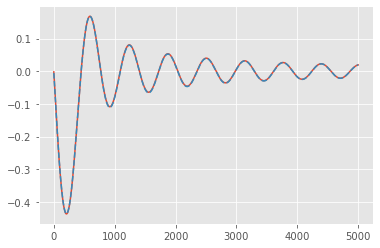

In [68]:
plt.plot(b)
plt.plot(a @ x, '--')

## Do the same thing with sympy.solve

In [50]:
x_2_syms = [sym.symbols('x_'+str(term), real=True) for term in range(a.shape[1])]

In [51]:
x_2_syms = np.array(x).reshape(-1,1)
x_2_syms

array([[x_0],
       [x_1],
       [x_2],
       [x_3],
       [x_4]], dtype=object)

In [52]:
a_2 = a @ x_2_syms
a_2

In [56]:
eqs = a_2 - b
eqs

array([[-0.999999833333342*x_0 + 0.166659781133957*x_1 + 11.9949492513223*x_2 - 5.05897660866212*x_3 - 0.746291680593902*x_4 + 0.00200028785425687],
       [-0.999979826853561*x_0 + 0.249981669225761*x_1 + 11.9443503772562*x_2 - 5.06644086906181*x_3 - 1.11826696203926*x_4 + 0.00366718571321201],
       [-0.999926476414568*x_0 + 0.33328255141437*x_1 + 11.8936021911054*x_2 - 5.08134597446929*x_3 - 1.48784681834877*x_4 + 0.00700082135280411],
       ...,
       [0.0056347316872351*x_0 - 0.00486184993555927*x_1 + 0.0156835785012175*x_2 + 0.215971468152891*x_3 - 0.0310421564656025*x_4 - 0.0193105930512802],
       [0.0054413478055689*x_0 - 0.00354889681134973*x_1 + 0.0178421292928854*x_2 + 0.21565027777081*x_3 - 0.0243524700141204*x_4 - 0.0193582454766106],
       [0.00524749707407858*x_0 - 0.00233340885046705*x_1 + 0.0199973605529316*x_2 + 0.215484331066179*x_3 - 0.0165916833627212*x_4 - 0.0193815837660914]],
      dtype=object)

In [62]:
x_2 = sym.solve(list(eqs.flatten()), list(x_2_syms.flatten()))
x_2

[]

Conclusion: Least squares method was actually less cumbersome and much faster. Also, solve doesn't work, even after lots of thinking! The thing is, it jumps straight to a numerical approach to this kind of problem. sympy.solve eventually will attempt some similar things, but it tries first many other, more analytical methods. I think when you have a system of 5000 simultaneous equations, sym.solve is too clever and slow an algorithm. Also, it will only be satisfied if there is a pefect solution. with 5000 equations and not totally accurate (rounding errors, numerical derivatives) values, no perfect solution will exist.

## Import DeepMoD style iterative version of least squares and compare results

In [20]:
alt_data = np.loadtxt('../data/StressStrain/FromDeepMoDStyle.csv', delimiter=',')

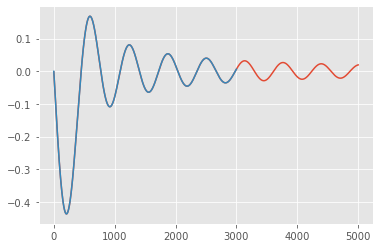

In [22]:
plt.plot(b)
#plt.plot(a @ x, '--')
plt.plot(alt_data)

In [23]:
alt_coeffs = np.loadtxt('../data/StressStrain/Up_to_30s_coeffs_DM_Style.csv', delimiter=',')

In [72]:
alt_coeffs = alt_coeffs.reshape(-1,1)
alt_coeffs

array([[5.84913529e-02],
       [5.02800662e-03],
       [4.01709266e-02],
       [8.42753500e-02],
       [6.30386639e-05]])

## Now import set of coeffs achived with DeepoMod but for 5000 datapoints, not 3000

In [29]:
alt_data_2 = np.loadtxt('../data/StressStrain/DM_Style_50.csv', delimiter=',')

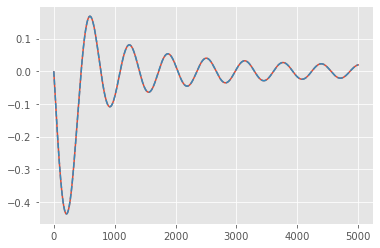

In [30]:
plt.plot(b)
#plt.plot(a @ x, '--')
plt.plot(alt_data_2, '--')

In [31]:
alt_coeffs_2 = np.loadtxt('../data/StressStrain/Up_to_50s_coeffs_DM_Style.csv', delimiter=',')

In [76]:
alt_coeffs_2 = alt_coeffs_2.reshape(-1,1)
alt_coeffs_2

array([[0.05865061],
       [0.00787085],
       [0.04008032],
       [0.08446718],
       [0.00041462]])

We observe a couple of things. First, the sets of coefficients all seem to perfectly fit the equation. Two, the coeffs are not all exactly teh same, though there is a lot of similarity. This implies more than one perfect solution.

Two things to now do, adjust teh volatile coeffs and see if the reason these vary is because they are small enoug to have no consequence.

Next, use these coeffs to rediscover model_params and see if theya re correct.

## rediscover model_params

In [35]:
model_params_from_coeffs(x, print_expressions=True)

[E_1*E_2/(E_1*eta_2 + E_2*eta_1), eta_1*eta_2/(E_1*eta_2 + E_2*eta_1), (E_0*E_1 + E_0*E_2 + E_1*E_2)/(E_0*(E_1*eta_2 + E_2*eta_1)), (E_0*eta_1 + E_0*eta_2 + E_1*eta_2 + E_2*eta_1)/(E_0*(E_1*eta_2 + E_2*eta_1)), eta_1*eta_2/(E_0*(E_1*eta_2 + E_2*eta_1))]
No solution possible for coefficient values and model complexity arrived at.


([], [E_0, E_1, E_2, eta_1, eta_2])

In [37]:
model_params_from_coeffs(alt_coeffs)

[E_1*E_2/(E_1*eta_2 + E_2*eta_1), eta_1*eta_2/(E_1*eta_2 + E_2*eta_1), (E_0*E_1 + E_0*E_2 + E_1*E_2)/(E_0*(E_1*eta_2 + E_2*eta_1)), (E_0*eta_1 + E_0*eta_2 + E_1*eta_2 + E_2*eta_1)/(E_0*(E_1*eta_2 + E_2*eta_1)), eta_1*eta_2/(E_0*(E_1*eta_2 + E_2*eta_1))]


([(79.7606787098014,
   13.9700687709119,
   1.65929688183531,
   0.0702622681279515,
   28.3598970434497)],
 [E_0, E_1, E_2, eta_1, eta_2])

In [38]:
model_params_from_coeffs(alt_coeffs_2)

([(18.9832933999502,
   31.7187234695643,
   1.66897748323285,
   0.249768614380987,
   28.4431244025140)],
 [E_0, E_1, E_2, eta_1, eta_2])

## Tweaks to varying coeffs

In [88]:
x_trial = x.copy()
x_trial

array([[0.05859044],
       [0.02076694],
       [0.04004238],
       [0.08491747],
       [0.00149178]])

In [73]:
abs(x-alt_coeffs)

array([[9.90844674e-05],
       [1.57389304e-02],
       [1.28546883e-04],
       [6.42115932e-04],
       [1.42874161e-03]])

In [77]:
abs(x-alt_coeffs_2)

array([[6.01754182e-05],
       [1.28960887e-02],
       [3.79403719e-05],
       [4.50285833e-04],
       [1.07716053e-03]])

In [78]:
abs(alt_coeffs-alt_coeffs_2)

array([[1.59259886e-04],
       [2.84284167e-03],
       [9.06065106e-05],
       [1.91830099e-04],
       [3.51581082e-04]])

In [89]:
x_trial[1,:] = 0
x_trial

array([[0.05859044],
       [0.        ],
       [0.04004238],
       [0.08491747],
       [0.00149178]])

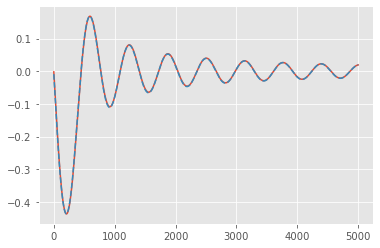

In [90]:
plt.plot(b)
plt.plot(a @ x_trial, '--')

In [91]:
x_trial[4,:] = 0
x_trial

array([[0.05859044],
       [0.        ],
       [0.04004238],
       [0.08491747],
       [0.        ]])

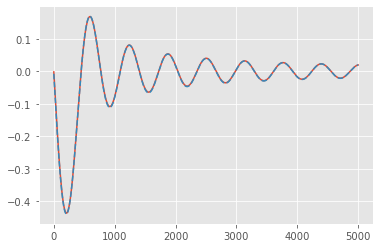

In [92]:
plt.plot(b)
plt.plot(a @ x_trial, '--')

In [93]:
x_trial[3,:] = 0.1
x_trial

array([[0.05859044],
       [0.        ],
       [0.04004238],
       [0.1       ],
       [0.        ]])

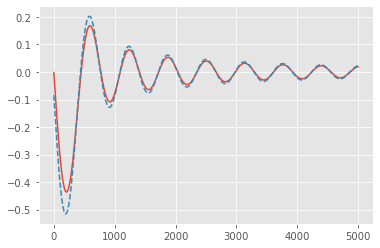

In [94]:
plt.plot(b)
plt.plot(a @ x_trial, '--')

In [97]:
x_trial[2,:] = 0.03
x_trial

array([[0.05859044],
       [0.        ],
       [0.03      ],
       [0.1       ],
       [0.        ]])

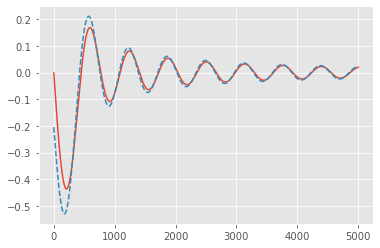

In [98]:
plt.plot(b)
plt.plot(a @ x_trial, '--')

In [99]:
x_trial[0,:] = 0.05
x_trial

array([[0.05],
       [0.  ],
       [0.03],
       [0.1 ],
       [0.  ]])

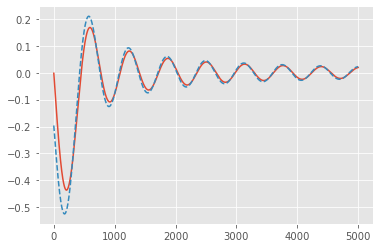

In [100]:
plt.plot(b)
plt.plot(a @ x_trial, '--')

These tweaks demonstrate reasonably well that, especially in the constants that were the most variable between the 3 methods of determination that worked, small changes to the constants did not have a large affect on the result of the RHS of the equation. Thus, their variance is explained by small changes to teh process in the method leaving artifacts and the numerical derivatives maybe not producing entirely consistant results. The DeepMoD method is also limited by the size of the lr, amongst probably other factors, and I don't know the lstsqs algorithm well enough to comment.